# Initialization

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, DataCollatorWithPadding,AutoModel
from torch.utils.data import WeightedRandomSampler, SubsetRandomSampler

from sklearn.utils import resample
import seaborn as sns
from transformers import AutoModelForSequenceClassification

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [2]:
%pip install nltk emoji==0.6.0

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os

# 1. Get the current working directory path
base_dir = os.path.abspath("")

# 2. Use os.path.join() to construct the file paths portably
# sentiment_file = os.path.join(base_dir, "dataset", "stock_data.csv")
stock_file = os.path.join(base_dir, "dataset", "stock_tweets.csv")

# Load the sentiment data from a CSV file
# sentiment_df = pd.read_csv(sentiment_file)
df = pd.read_csv("hf://datasets/StephanAkkerman/financial-tweets/financial_tweets.csv")
# Load the stock data from a CSV file
stock_df = pd.read_csv(stock_file)

In [ ]:
# Keep only relevant columns
sentiment_df = df[["description", "sentiment"]].copy()

# Filter only valid sentiment labels
sentiment_df = sentiment_df[sentiment_df["sentiment"].isin(["Bullish", "Neutral", "Bearish"])]

# Map text labels to numeric values
label_map = {"Bearish": 0, "Neutral": 1, "Bullish": 2}
sentiment_df["sentiment"] = sentiment_df["sentiment"].map(label_map)

In [ ]:
# Check the final columns
print(sentiment_df.columns)
print(stock_df.columns)

print(f"\nTotal elements in sentiment_df (via shape): {sentiment_df.shape[0]}")
print(f"Total elements in stock_df (via shape): {stock_df.shape[0]}")

Index(['description', 'sentiment'], dtype='object')
Index(['Date', 'Tweet', 'Stock Name', 'Company Name'], dtype='object')

Total elements in sentiment_df (via shape): 44426
Total elements in stock_df (via shape): 80793


In [6]:
def plot_distribution(df, label_column, title_prefix, color='skyblue'):
    """
    Plots and prints the count and ratio distribution for a categorical column.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to analyze.
    label_column : str
        The name of the column containing categorical labels (e.g., company, sentiment).
    title_prefix : str
        Prefix for the plot title (e.g., 'Company', 'Sentiment').
    color : str, optional
        Color for the bar plot (default is 'skyblue').

    Returns
    -------
    tuple
        (counts, ratios) as pandas Series objects.
    """
    # Count occurrences
    counts = df[label_column].value_counts()
    ratios = counts / counts.sum()

    # Plot distribution
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar', color=color)
    plt.title(f'{title_prefix} Distribution')
    plt.xlabel(title_prefix)
    plt.ylabel('Number of Records')
    plt.xticks(rotation=45 if title_prefix.lower() == 'company' else 0, ha='right')
    plt.tight_layout()
    plt.show()

    # Display results
    print(f"=== {title_prefix} Ratios ===")
    print(ratios)
    print(f"\n=== {title_prefix} Counts ===")
    print(counts)
    
    return counts, ratios

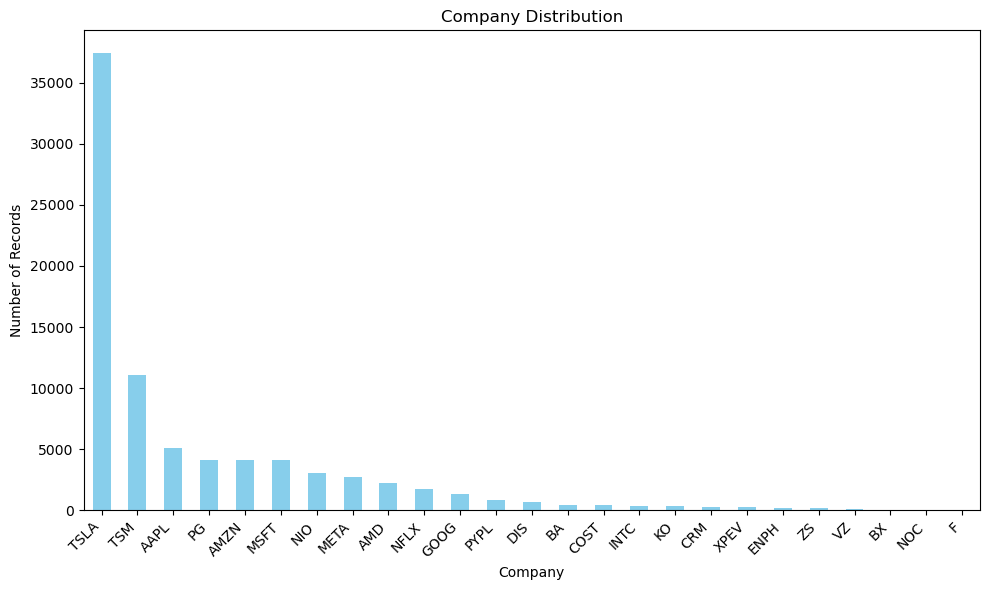

=== Company Ratios ===
Stock Name
TSLA    0.463184
TSM     0.136571
AAPL    0.062580
PG      0.050611
AMZN    0.050611
MSFT    0.050611
NIO     0.037392
META    0.034050
AMD     0.027564
NFLX    0.021376
GOOG    0.015979
PYPL    0.010434
DIS     0.007860
BA      0.004939
COST    0.004864
INTC    0.003899
KO      0.003837
CRM     0.002884
XPEV    0.002785
ENPH    0.002673
ZS      0.002389
VZ      0.001522
BX      0.000619
NOC     0.000384
F       0.000384
Name: count, dtype: float64

=== Company Counts ===
Stock Name
TSLA    37422
TSM     11034
AAPL     5056
PG       4089
AMZN     4089
MSFT     4089
NIO      3021
META     2751
AMD      2227
NFLX     1727
GOOG     1291
PYPL      843
DIS       635
BA        399
COST      393
INTC      315
KO        310
CRM       233
XPEV      225
ENPH      216
ZS        193
VZ        123
BX         50
NOC        31
F          31
Name: count, dtype: int64


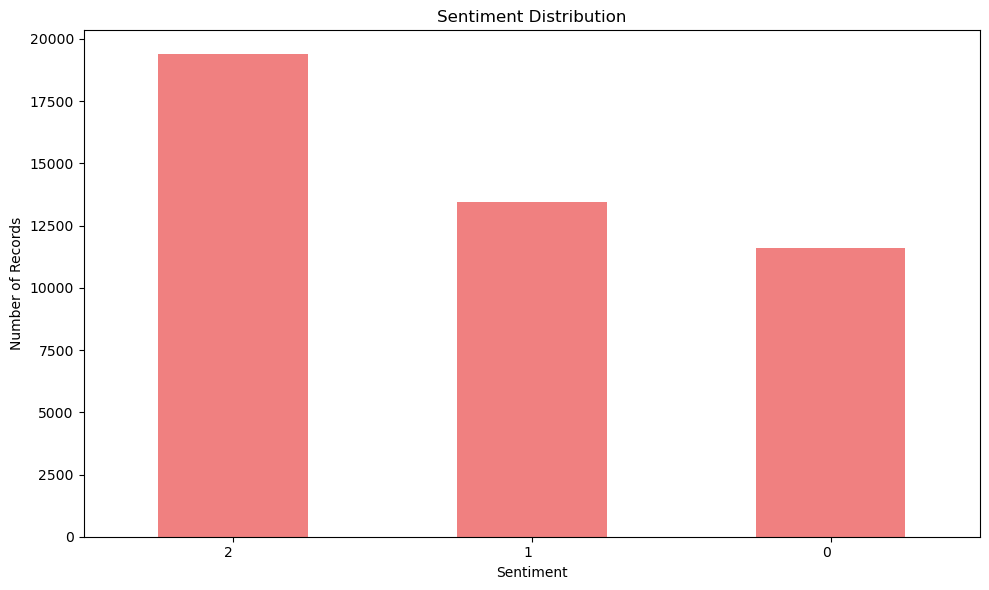

=== Sentiment Ratios ===
sentiment
2    0.436186
1    0.302458
0    0.261356
Name: count, dtype: float64

=== Sentiment Counts ===
sentiment
2    19378
1    13437
0    11611
Name: count, dtype: int64


In [7]:
# For Stock DataFrame
stock_counts, stock_ratios = plot_distribution(
    df=stock_df, 
    label_column='Stock Name', 
    title_prefix='Company',
    color='skyblue'
)

# For Sentiment DataFrame
sentiment_counts, sentiment_ratios = plot_distribution(
    df=sentiment_df, 
    label_column='sentiment', 
    title_prefix='Sentiment',
    color='lightcoral'
)

In [8]:
def get_balanced_subset(df_name: pd.DataFrame, df_column_name: str, num: int, random_state: int = 42) -> pd.DataFrame:
    """
    Returns a roughly balanced subset of size `num` from the given DataFrame.
    
    Parameters
    ----------
    df_name : pd.DataFrame
        The input dataset.
    df_column_name : str
        The name of the column containing class labels.
    num : int
        The total number of samples desired.
    random_state : int, optional
        Random seed for reproducibility (default=42).
    
    Returns
    -------
    pd.DataFrame
        A subset of the original DataFrame with roughly balanced class distribution.
    """
    # Unique classes and samples per class
    classes = df_name[df_column_name].unique()
    samples_per_class = num // len(classes)
    
    balanced_subset = []
    
    for c in classes:
        class_subset = df_name[df_name[df_column_name] == c]
        
        # Sample from each class
        subset = resample(class_subset,
                          replace=False,
                          n_samples=min(len(class_subset), samples_per_class),
                          random_state=random_state)
        balanced_subset.append(subset)
    
    # Combine and shuffle
    balanced_df = pd.concat(balanced_subset)
    balanced_df = balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    return balanced_df

In [9]:
stock_df_balanced = get_balanced_subset(df_name=stock_df, df_column_name='Stock Name', num=sentiment_df.shape[0])
sentiment_df_balanced = get_balanced_subset(df_name=sentiment_df, df_column_name='sentiment', num=stock_df_balanced.shape[0])

In [10]:
print(stock_df_balanced.shape[0])
print(sentiment_df_balanced.shape[0])

23008
23007


## Preprocessing

In [11]:
from TweetNormalizer import normalizeTweet

Clean DFs by removing not required classes

In [ ]:
# =========================================
# STOCK_DF PROCESSING WITH "OTHERS" GROUPING
# =========================================

# Set threshold for minimum samples per class
MIN_SAMPLES_PER_CLASS = 200  

# 1. Create a unique pair identifier combining Stock Name and Company Name
stock_df_processed = stock_df_balanced.copy()
stock_df_processed["pair"] = stock_df_processed["Stock Name"] + "___" + stock_df_processed["Company Name"]

# 2. Count samples per pair to identify small classes
pair_counts = stock_df_processed["pair"].value_counts()
frequent_pairs = pair_counts[pair_counts >= MIN_SAMPLES_PER_CLASS].index.tolist()
rare_pairs = pair_counts[pair_counts < MIN_SAMPLES_PER_CLASS].index.tolist()

print("\n" + "="*80)
print(f"CLASS GROUPING ANALYSIS (Threshold: {MIN_SAMPLES_PER_CLASS} samples)")
print("="*80)
print(f"Pairs kept as separate classes: {len(frequent_pairs)}")
print(f"Pairs grouped into 'Others': {len(rare_pairs)}")
print(f"Total samples in 'Others': {pair_counts[rare_pairs].sum()}")
print("="*80)

# 3. Create mapping: frequent pairs get unique IDs, rare pairs → "OTHERS"
pair_to_id = {pair: idx for idx, pair in enumerate(sorted(frequent_pairs))}
OTHERS_ID = len(pair_to_id)
pair_to_id["OTHERS"] = OTHERS_ID

# Add all rare pairs to map to OTHERS_ID
for rare_pair in rare_pairs:
    pair_to_id[rare_pair] = OTHERS_ID

# 4. Create the numeric 'label_clas' column
stock_df_processed["label_clas"] = stock_df_processed["pair"].map(pair_to_id)

# 5. Display mapping BEFORE dropping columns
print("\n📊 Stock Classification Mapping:")
print("-" * 80)

# Show frequent classes
for pair in sorted(frequent_pairs):
    class_id = pair_to_id[pair]
    stock, company = pair.split("___")
    count = (stock_df_processed["label_clas"] == class_id).sum()
    print(f"{class_id:2d} | {stock:6s} | {company:30s} | {count:3d} samples")

# Show "Others" class
print("-" * 80)
count_others = (stock_df_processed["label_clas"] == OTHERS_ID).sum()
print(f"{OTHERS_ID:2d} | OTHERS | {f'({len(rare_pairs)} stocks grouped)':<30s} | {count_others:3d} samples")
print("-" * 80)

# Show which stocks were grouped into "Others"
print(f"\n📦 Stocks grouped into 'Others' category (ID={OTHERS_ID}):")
print("-" * 80)
for rare_pair in sorted(rare_pairs):
    stock, company = rare_pair.split("___")
    count = pair_counts[rare_pair]
    print(f"   {stock:6s} | {company:30s} | {count:3d} samples")
print("-" * 80)

# Print final summary
print(f"\n✅ Final number of classes: {len(set(pair_to_id.values()))}")
print(f"   - Named classes: {len(frequent_pairs)}")
print(f"   - 'Others' class: 1")
print("="*80 + "\n")

# 6. Drop temporary and unnecessary columns
columns_to_drop = ["pair", "Stock Name", "Date", "Company Name"]
stock_df_processed.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# 7. Rename 'Tweet' column to 'text' to match sentiment_df
stock_df_processed.rename(columns={"Tweet": "text"}, inplace=True)
stock_df_processed["text"] = stock_df_processed["text"].astype(str)

# 8. Normalize text
stock_df_processed["text"] = stock_df_processed["text"].apply(normalizeTweet)

# 9. Inspect
print("Stock DataFrame Head after processing:")
print(stock_df_processed.head())
print("\nFinal Columns in stock_df_processed:")
print(stock_df_processed.columns)
print(f"Label distribution:\n{stock_df_processed['label_clas'].value_counts().sort_index()}")

# =========================================
# SENTIMENT_DF PROCESSING
# =========================================
sentiment_df_processed = sentiment_df_balanced.copy()

# 1. Rename columns to match stock_df
sentiment_df_processed.rename(columns={"description": "text", "sentiment": "label_sen"}, inplace=True)
sentiment_df_processed["text"] = sentiment_df_processed["text"].astype(str)

# 2. Normalize text
sentiment_df_processed["text"] = sentiment_df_processed["text"].apply(normalizeTweet)

# 3. Inspect
print("\nSentiment DataFrame Head after processing:")
print(sentiment_df_processed.head())
print("\nFinal Columns in sentiment_df_processed:")
print(sentiment_df_processed.columns)

# =========================================
# SAVE MAPPING FOR FUTURE REFERENCE
# =========================================
# Create reverse mapping for easy lookup during inference
id_to_info = {}
for pair, class_id in pair_to_id.items():
    if pair == "OTHERS":
        id_to_info[class_id] = {"stock": "OTHERS", "company": "Multiple", "is_others": True}
    elif pair in frequent_pairs:
        stock, company = pair.split("___")
        id_to_info[class_id] = {"stock": stock, "company": company, "is_others": False}

# Save for later use
import json
with open("class_mapping.json", "w") as f:
    json.dump({
        "pair_to_id": {k: v for k, v in pair_to_id.items() if k in frequent_pairs or k == "OTHERS"},
        "id_to_info": id_to_info,
        "min_samples_threshold": MIN_SAMPLES_PER_CLASS,
        "num_classes": len(set(pair_to_id.values()))
    }, f, indent=2)

print("\n✅ Class mapping saved to 'class_mapping.json'")



CLASS GROUPING ANALYSIS (Threshold: 200 samples)
Pairs kept as separate classes: 20
Pairs grouped into 'Others': 5
Total samples in 'Others': 428

📊 Stock Classification Mapping:
--------------------------------------------------------------------------------
 0 | AAPL   | Apple Inc.                     | 1777 samples
 1 | AMD    | Advanced Micro Devices, Inc.   | 1777 samples
 2 | AMZN   | Amazon.com, Inc.               | 1777 samples
 3 | BA     | The Boeing Company             | 399 samples
 4 | COST   | Costco Wholesale Corporation   | 393 samples
 5 | CRM    | Salesforce, Inc.               | 233 samples
 6 | DIS    | The Walt Disney Company        | 635 samples
 7 | ENPH   | Enphase Energy, Inc.           | 216 samples
 8 | GOOG   | Alphabet Inc.                  | 1291 samples
 9 | INTC   | Intel Corporation              | 315 samples
10 | KO     | The Coca-Cola Company          | 310 samples
11 | META   | Meta Platforms, Inc.           | 1777 samples
12 | MSFT   | Microsoft Co

From the below graph we can see that the data is very skewed

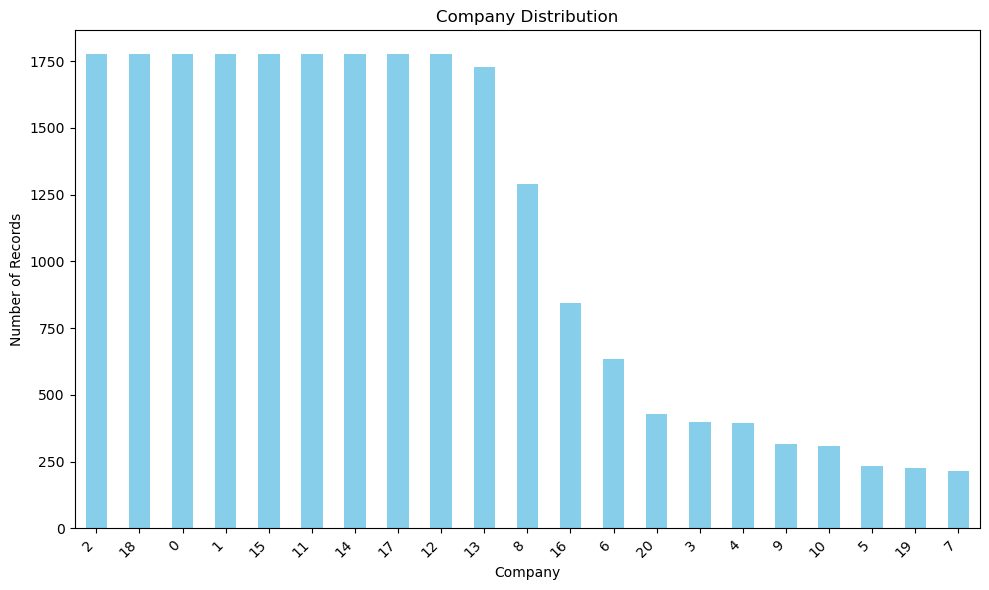

=== Company Ratios ===
label_clas
2     0.077234
18    0.077234
0     0.077234
1     0.077234
15    0.077234
11    0.077234
14    0.077234
17    0.077234
12    0.077234
13    0.075061
8     0.056111
16    0.036639
6     0.027599
20    0.018602
3     0.017342
4     0.017081
9     0.013691
10    0.013474
5     0.010127
19    0.009779
7     0.009388
Name: count, dtype: float64

=== Company Counts ===
label_clas
2     1777
18    1777
0     1777
1     1777
15    1777
11    1777
14    1777
17    1777
12    1777
13    1727
8     1291
16     843
6      635
20     428
3      399
4      393
9      315
10     310
5      233
19     225
7      216
Name: count, dtype: int64


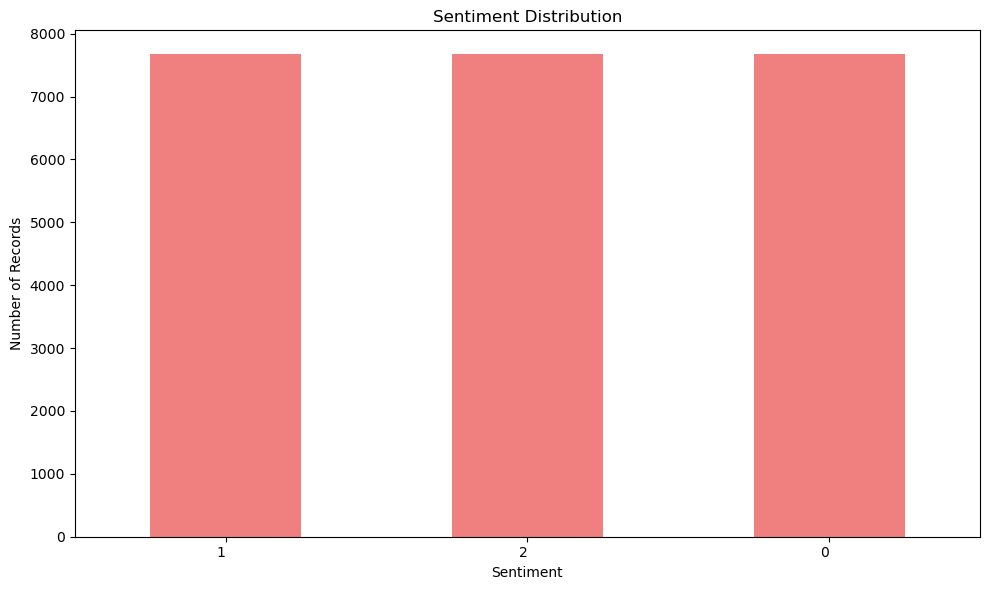

=== Sentiment Ratios ===
label_sen
1    0.333333
2    0.333333
0    0.333333
Name: count, dtype: float64

=== Sentiment Counts ===
label_sen
1    7669
2    7669
0    7669
Name: count, dtype: int64


In [13]:
# For Stock DataFrame
stock_counts, stock_ratios = plot_distribution(
    df=stock_df_processed, 
    label_column='label_clas', 
    title_prefix='Company',
    color='skyblue'
)

# For Sentiment DataFrame
sentiment_counts, sentiment_ratios = plot_distribution(
    df=sentiment_df_processed, 
    label_column='label_sen', 
    title_prefix='Sentiment',
    color='lightcoral'
)

In [15]:
from sklearn.model_selection import train_test_split

def create_small_dataset(df, sample_frac=0.1, val_frac=0.1, test_frac=0.1, random_state=42):
    """
    Splits a dataset into train, validation, and test sets.
    
    Parameters:
    - df : pandas.DataFrame
        The original dataset.
    - sample_frac : float
        Fraction of the dataset to sample for a small dataset.
    - val_frac : float
        Fraction of the dataset to use as validation (from the sampled data).
    - test_frac : float
        Fraction of the dataset to use as test (from the sampled data).
    - random_state : int
        Seed for reproducibility.
        
    Returns:
    - train_df, val_df, test_df : pandas.DataFrame
    """
    # Step 1: Sample a smaller subset
    small_df = df.sample(frac=sample_frac, random_state=random_state).reset_index(drop=True)
    
    # Step 2: Split into train+temp and test
    train_temp, test_df = train_test_split(
        small_df, test_size=test_frac, random_state=random_state
    )
    
    # Step 3: Split train_temp into train and validation
    val_relative_frac = val_frac / (1 - test_frac)  # Adjust val fraction relative to remaining data
    train_df, val_df = train_test_split(
        train_temp, test_size=val_relative_frac, random_state=random_state
    )
    
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [16]:
# Step 1: Add missing labels
stock_df_processed['label_sen'] = -10
sentiment_df_processed['label_clas'] = -10

# BASICALLY A TINY DATASET
# Step 2: Split each dataset separately
train_stock, val_stock, test_stock = create_small_dataset(
    stock_df_processed, sample_frac=1.0, val_frac=0.125, test_frac=0.125
)

train_sent, val_sent, test_sent = create_small_dataset(
    sentiment_df_processed, sample_frac=1.0, val_frac=0.125, test_frac=0.125
)

# Step 3: Merge corresponding splits
train_df = pd.concat([train_stock, train_sent], ignore_index=True)
val_df   = pd.concat([val_stock, val_sent], ignore_index=True)
test_df  = pd.concat([test_stock, test_sent], ignore_index=True)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

# Optional: merge all for full dataset (if needed)
super_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
print(super_df.head())

# Step 4: Load tokenizer
model_name = "StephanAkkerman/FinTwitBERT-sentiment"
# model_name = "/home/ashstar114/finTweetAnal/FinTwitBERT-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=False)

# Step 5: Convert dataframe to dataset
super_dataset = load_custom_dataframe(super_df, tokenizer)
print(super_dataset)

Train size: 34511
Validation size: 5752
Test size: 5752
                                                text  label_clas  label_sen
0  This $ CYBL tweet has more clues than you thin...          20        -10
1  Seth Klarman trims $ GOOG , $ FB & $ MU in Q4 ...           8        -10
2  Worst performing large cap stocks so far in 20...          13        -10
3  Plan on holding $ AMD overnight would consider...           1        -10
4  People been asking about when I would buy the ...           0        -10


Map:   0%|          | 0/46015 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label_clas', 'label_sen', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 46015
})


In [17]:
# Load pretrained sentiment model
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Add a new parallel head for your classification task
company_counts = len(stock_counts)
num_new_classes = company_counts
num_sentiment_classes = 3
# new_head = nn.Linear(model.config.hidden_size, num_new_classes)

class HeadCNN(nn.Module):
    def __init__(self, new_num_classes, in_features=768):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 1024)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1024, new_num_classes)
        self.final_act = nn.Identity()

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        x = self.final_act(x)
        return x  # shape [B, new_num_classes]
        
class FrozenBERTMultiHead(nn.Module):
    def __init__(self, model_name, num_sentiment_classes=num_sentiment_classes, num_new_classes=num_new_classes):
        super().__init__()
        # Load pretrained sentiment model
        self.bert_model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels = num_sentiment_classes  # change sentiment head output size
        )


        # New classification head
        self.new_head = HeadCNN(in_features=self.bert_model.config.hidden_size,
                                new_num_classes=num_new_classes)

    def forward(self, input_ids, attention_mask,**kwargs):
        # Get shared BERT embeddings
        outputs = self.bert_model.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token

        # Compute logits for both heads
        sentiment_logits = self.bert_model.classifier(cls_embedding)
        clas_logits = self.new_head(cls_embedding)

        return sentiment_logits, clas_logits

In [19]:
class DualTaskConsistencyLoss(nn.Module):
    """
    Multi-task semi-supervised consistency loss:
        L = L_GT + λ * L_semi
    Maintains masking structure for labeled and unlabeled data.
    """

    def __init__(self, lambda_weight=1.0, ignore_index=-10,weights = None):
        super().__init__()
        self.lambda_weight = lambda_weight
        self.ignore_index = ignore_index
        self.ce_loss_class = nn.CrossEntropyLoss(ignore_index=ignore_index,weight=weights)
        self.ce_loss_sen = nn.CrossEntropyLoss(ignore_index=ignore_index)
        self.kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=True)

    def forward(self, out_A_sen, out_A_clas, out_B_sen, out_B_clas, labels_clas, labels_sen):
        # print("Shapes of tensors:")
        # print("out_A_sen:", out_A_sen.shape)
        # print("out_A_clas:", out_A_clas.shape)
        # print("out_B_sen:", out_B_sen.shape)
        # print("out_B_clas:", out_B_clas.shape)
        # print("labels_clas:", labels_clas.shape)
        # print("labels_sen:", labels_sen.shape)
        # print("Classification labels min/max:", labels_clas.min().item(), labels_clas.max().item())
        # print("Sentiment labels min/max:", labels_sen.min().item(), labels_sen.max().item())

        # -----------------------------
        # 1. Rename tensors for masking logic
        # -----------------------------
        L_1, L_2 = out_A_clas, out_A_sen  # Model A predictions
        R_1, R_2 = out_B_clas, out_B_sen  # Model B predictions

        # -----------------------------
        # 2. Masks for valid labels
        # -----------------------------
        mask_A = labels_clas != self.ignore_index  # Classification labels
        mask_B = labels_sen != self.ignore_index   # Sentiment labels

        Y_1_A = labels_clas[mask_A]  # Ground truth classification
        Y_2_B = labels_sen[mask_B]   # Ground truth sentiment

        # -----------------------------
        # 3. Apply masks to predictions
        # -----------------------------
        L_1_A = L_1[mask_A]
        R_1_A = R_1[mask_A]
        L_2_B = L_2[mask_B]
        R_2_B = R_2[mask_B]

        # Predictions for consistency loss
        L_2_A = L_2[mask_A]
        R_2_A = R_2[mask_A]
        L_1_B = L_1[mask_B]
        R_1_B = R_1[mask_B]

        # Optional: task-specific outputs (if needed)
        outputs_A_clas = L_1_A
        outputs_A_sent = L_2_B
        outputs_B_clas = R_1_A
        outputs_B_sent = R_2_B

        # -----------------------------
        # 4. Supervised Loss L_GT
        # -----------------------------
        L_GT = 0
        if mask_A.any():
            L_GT += self.ce_loss_class(L_1_A, Y_1_A)
            L_GT += self.ce_loss_class(R_1_A, Y_1_A)
        if mask_B.any():
            L_GT += self.ce_loss_sen(L_2_B, Y_2_B)
            L_GT += self.ce_loss_sen(R_2_B, Y_2_B)

        # -----------------------------
        # 5. Unlabeled consistency loss L_semi_u (KL divergence)
        # -----------------------------
        L_semi_u = 0
        if mask_A.any():
            log_L2A = F.log_softmax(L_2_A, dim=1)
            log_R2A = F.log_softmax(R_2_A, dim=1)
            L_semi_u += self.kl_loss(log_L2A, log_R2A)
            L_semi_u += self.kl_loss(log_R2A, log_L2A)
        if mask_B.any():
            log_L1B = F.log_softmax(L_1_B, dim=1)
            log_R1B = F.log_softmax(R_1_B, dim=1)
            L_semi_u += self.kl_loss(log_L1B, log_R1B)
            L_semi_u += self.kl_loss(log_R1B, log_L1B)

        # -----------------------------
        # 6. Labeled consistency loss L_semi_l (optional)
        # -----------------------------
        L_semi_l = 0
        # if mask_A.any():
        #     L_semi_l += self.ce_loss_class(L_1_A, R_1_A.argmax(dim=1))
        #     L_semi_l += self.ce_loss_class(R_1_A, L_1_A.argmax(dim=1))
        # if mask_B.any():
        #     L_semi_l += self.ce_loss_sen(L_2_B, R_2_B.argmax(dim=1))
        #     L_semi_l += self.ce_loss_sen(R_2_B, L_2_B.argmax(dim=1))
        if mask_A.any():
            log_L1A = F.log_softmax(L_1_A, dim=1)
            log_R1A = F.log_softmax(R_1_A, dim=1)
            L_semi_l += self.kl_loss(log_L1A, log_R1A)
            L_semi_l += self.kl_loss(log_R1A, log_L1A)
        if mask_B.any():
            log_L2B = F.log_softmax(L_2_B, dim=1)
            log_R2B = F.log_softmax(R_2_B, dim=1)
            L_semi_l += self.kl_loss(log_L2B, log_R2B)
            L_semi_l += self.kl_loss(log_R2B, log_L2B)

        # -----------------------------
        # 7. Total semi-supervised loss
        # -----------------------------
        L_semi = L_semi_u + L_semi_l

        # -----------------------------
        # 8. Total loss
        # -----------------------------
        total_loss = L_GT + self.lambda_weight * L_semi

        logs = {
            "L_total": total_loss.item(),
            "L_GT": L_GT.item(),
            "L_semi_u": L_semi_u.item(),
            "L_semi_l": L_semi_l.item(),
            "L_semi": L_semi.item()
        }

        return total_loss, logs

In [20]:
import torch
import torch.nn.functional as F

class AccumulatingMetric:
    """Accumulate samples of a metric and automatically keep track of the number of samples."""
    def __init__(self):
        self.metric = 0.0
        self.counter = 0

    def add(self, value):
        self.metric += value
        self.counter += 1

    def avg(self):
        return self.metric / self.counter if self.counter > 0 else 0.0


def accuracy(pred, label):
    """Compute accuracy."""
    hard_pred = pred.argmax(1)
    return (hard_pred == label).float().mean().item()


# ===============================================================
#                     TRAINING LOOP
# ===============================================================

def train_epoch(
    model_A, model_B,
    train_loader,
    optimizer_A, optimizer_B,
    scheduler_A, scheduler_B,
    device,
    loss_fn
):
    """Train one epoch for two models in parallel that supervise each other."""
    model_A.train()
    model_B.train()

    # Metrics
    train_loss = AccumulatingMetric()
    acc_A_taskA = AccumulatingMetric()
    acc_A_taskB = AccumulatingMetric()
    acc_B_taskA = AccumulatingMetric()
    acc_B_taskB = AccumulatingMetric()

    # Track individual loss components (only used if not train_clas)
    log_L_total = AccumulatingMetric()
    log_L_GT = AccumulatingMetric()
    log_L_semi_u = AccumulatingMetric()
    log_L_semi_l = AccumulatingMetric()
    log_L_semi = AccumulatingMetric()

    for batch in train_loader:
        # Move batch to device
        for key, val in batch.items():
            batch[key] = val.to(device)

        model_A.to(device)
        model_B.to(device)

        # ---- Forward pass for both models ----
        out_A_sen, out_A_clas = model_A(batch["input_ids"], batch["attention_mask"])
        out_B_sen, out_B_clas = model_B(batch["input_ids"], batch["attention_mask"])

        # ---- Compute total loss and logs ----
        total_loss_batch, logs = loss_fn(
            out_A_sen, out_A_clas,
            out_B_sen, out_B_clas,
            batch["label_clas"], batch["label_sen"]
        )

        # ---- Backward passes ----
        optimizer_A.zero_grad()
        optimizer_B.zero_grad()

        total_loss_batch.backward()
        optimizer_A.step()
        optimizer_B.step()
        scheduler_A.step()
        scheduler_B.step()

        # ---- Track metrics ----
        train_loss.add(total_loss_batch.item())


        log_L_total.add(logs["L_total"])
        log_L_GT.add(logs["L_GT"])
        log_L_semi_u.add(logs["L_semi_u"])
        log_L_semi_l.add(logs["L_semi_l"])
        log_L_semi.add(logs["L_semi"])

        # ---- Compute accuracies for both tasks of both models ----
        mask_clas = batch["label_clas"] != -10
        mask_sen = batch["label_sen"] != -10

        if mask_clas.any():
            acc_A_taskA.add(accuracy(out_A_clas[mask_clas], batch["label_clas"][mask_clas]))
            acc_B_taskA.add(accuracy(out_B_clas[mask_clas], batch["label_clas"][mask_clas]))

        if mask_sen.any():
            acc_A_taskB.add(accuracy(out_A_sen[mask_sen], batch["label_sen"][mask_sen]))
            acc_B_taskB.add(accuracy(out_B_sen[mask_sen], batch["label_sen"][mask_sen]))

    # ---- Return metrics ----
    result = {
        "loss": train_loss.avg(),
        "acc_A_taskA": acc_A_taskA.avg(),
        "acc_A_taskB": acc_A_taskB.avg(),
        "acc_B_taskA": acc_B_taskA.avg(),
        "acc_B_taskB": acc_B_taskB.avg()
    }


    result["logs"] = {
        "L_total": log_L_total.avg(),
        "L_GT": log_L_GT.avg(),
        "L_semi_u": log_L_semi_u.avg(),
        "L_semi_l": log_L_semi_l.avg(),
        "L_semi": log_L_semi.avg()
    }

    return result



# ===============================================================
#                     VALIDATION LOOP
# ===============================================================

def validate_epoch(model_A, model_B, val_loader, device, loss_fn):
    """
    Validation for two models supervising each other.

    Args:
        model_A, model_B: The two models to validate.
        val_loader: Validation DataLoader.
        device: torch device.
        loss_fn: DualTaskConsistencyLoss or classification loss function.
        train_clas: whether to validate only classification.
        ignore_index: label to ignore in metrics.

    Returns:
        Dictionary of average losses and accuracies.
    """
    model_A.eval()
    model_B.eval()

    # Metric trackers
    val_loss = AccumulatingMetric()
    acc_A_taskA = AccumulatingMetric()
    acc_A_taskB = AccumulatingMetric()
    acc_B_taskA = AccumulatingMetric()
    acc_B_taskB = AccumulatingMetric()

    # Optional loss logs for dual-task mode
    log_L_total = AccumulatingMetric()
    log_L_GT = AccumulatingMetric()
    log_L_semi_u = AccumulatingMetric()
    log_L_semi_l = AccumulatingMetric()
    log_L_semi = AccumulatingMetric()

    with torch.no_grad():
        for batch in val_loader:
            # Move batch to device
            for key, val in batch.items():
                batch[key] = val.to(device)

            model_A.to(device)
            model_B.to(device)

            # Forward pass
            out_A_sen, out_A_clas = model_A(batch["input_ids"], batch["attention_mask"])
            out_B_sen, out_B_clas = model_B(batch["input_ids"], batch["attention_mask"])


            total_loss_batch, logs = loss_fn(
                out_A_sen, out_A_clas,
                out_B_sen, out_B_clas,
                batch["label_clas"], batch["label_sen"]
            )

            val_loss.add(total_loss_batch.item())

            log_L_total.add(logs["L_total"])
            log_L_GT.add(logs["L_GT"])
            log_L_semi_u.add(logs["L_semi_u"])
            log_L_semi_l.add(logs["L_semi_l"])
            log_L_semi.add(logs["L_semi"])

            # Compute accuracies for both tasks
            mask_clas = batch["label_clas"] != -10
            mask_sen = batch["label_sen"] != -10

            if mask_clas.any():
                acc_A_taskA.add(accuracy(out_A_clas[mask_clas], batch["label_clas"][mask_clas]))
                acc_B_taskA.add(accuracy(out_B_clas[mask_clas], batch["label_clas"][mask_clas]))

            if mask_sen.any():
                acc_A_taskB.add(accuracy(out_A_sen[mask_sen], batch["label_sen"][mask_sen]))
                acc_B_taskB.add(accuracy(out_B_sen[mask_sen], batch["label_sen"][mask_sen]))

    result = {
        "loss": val_loss.avg(),
        "acc_A_taskA": acc_A_taskA.avg(),
        "acc_A_taskB": acc_A_taskB.avg(),
        "acc_B_taskA": acc_B_taskA.avg(),
        "acc_B_taskB": acc_B_taskB.avg()
    }


    result["logs"] = {
        "L_total": log_L_total.avg(),
        "L_GT": log_L_GT.avg(),
        "L_semi_u": log_L_semi_u.avg(),
        "L_semi_l": log_L_semi_l.avg(),
        "L_semi": log_L_semi.avg()
    }

    return result

def train_epoch_class_only(
    model_A, model_B,
    train_loader,
    optimizer_A, optimizer_B,
    scheduler_A, scheduler_B,
    device,
    weights_clas = None
):
    """
    Train one epoch for two models focusing ONLY on the classification head.
    Sentiment head is ignored. Each model's loss is backpropagated separately.
    """
    model_A.train()
    model_B.train()

    # Metrics
    train_loss_A = AccumulatingMetric()
    train_loss_B = AccumulatingMetric()
    acc_A_taskA = AccumulatingMetric()
    acc_B_taskA = AccumulatingMetric()

    for batch in train_loader:
        # Move batch to device
        for key, val in batch.items():
            batch[key] = val.to(device)

        model_A.to(device)
        model_B.to(device)

        # ---- Forward pass ----
        _, out_A_clas = model_A(batch["input_ids"], batch["attention_mask"])
        _, out_B_clas = model_B(batch["input_ids"], batch["attention_mask"])

        # ---- Compute individual losses ----
        mask_clas = batch["label_clas"] != -10
        if mask_clas.any():
            loss_A = F.cross_entropy(out_A_clas[mask_clas], batch["label_clas"][mask_clas],weight=weights_clas)
            loss_B = F.cross_entropy(out_B_clas[mask_clas], batch["label_clas"][mask_clas],weight=weights_clas)
        else:
            # Skip batch if no valid labels
            continue

        # ---- Backward passes individually ----
        optimizer_A.zero_grad()
        loss_A.backward()
        optimizer_A.step()
        scheduler_A.step()

        optimizer_B.zero_grad()
        loss_B.backward()
        optimizer_B.step()
        scheduler_B.step()

        # ---- Track metrics ----
        train_loss_A.add(loss_A.item())
        train_loss_B.add(loss_B.item())

        acc_A_taskA.add(accuracy(out_A_clas[mask_clas], batch["label_clas"][mask_clas]))
        acc_B_taskA.add(accuracy(out_B_clas[mask_clas], batch["label_clas"][mask_clas]))

    # ---- Return metrics ----
    return {
        "loss_A": train_loss_A.avg(),
        "loss_B": train_loss_B.avg(),
        "acc_A_taskA": acc_A_taskA.avg(),
        "acc_B_taskA": acc_B_taskA.avg()
    }

def validate_epoch_class_only(
    model_A, model_B,
    val_loader,
    device
):
    """
    Validation for two models focusing ONLY on the classification head.
    Sentiment head is ignored.
    """
    model_A.eval()
    model_B.eval()

    # Metric trackers
    val_loss_A = AccumulatingMetric()
    val_loss_B = AccumulatingMetric()
    acc_A_taskA = AccumulatingMetric()
    acc_B_taskA = AccumulatingMetric()

    with torch.no_grad():
        for batch in val_loader:
            # Move batch to device
            for key, val in batch.items():
                batch[key] = val.to(device)

            model_A.to(device)
            model_B.to(device)

            # ---- Forward pass ----
            _, out_A_clas = model_A(batch["input_ids"], batch["attention_mask"])
            _, out_B_clas = model_B(batch["input_ids"], batch["attention_mask"])

            # ---- Compute individual losses ----
            mask_clas = batch["label_clas"] != -10
            if not mask_clas.any():
                continue  # skip batch if no valid labels

            loss_A = F.cross_entropy(out_A_clas[mask_clas], batch["label_clas"][mask_clas])
            loss_B = F.cross_entropy(out_B_clas[mask_clas], batch["label_clas"][mask_clas])

            # ---- Track metrics ----
            val_loss_A.add(loss_A.item())
            val_loss_B.add(loss_B.item())

            acc_A_taskA.add(accuracy(out_A_clas[mask_clas], batch["label_clas"][mask_clas]))
            acc_B_taskA.add(accuracy(out_B_clas[mask_clas], batch["label_clas"][mask_clas]))

    # ---- Return metrics ----
    return {
        "loss_A": val_loss_A.avg(),
        "loss_B": val_loss_B.avg(),
        "acc_A_taskA": acc_A_taskA.avg(),
        "acc_B_taskA": acc_B_taskA.avg()
    }




In [21]:
def init_head_weights(module):
    """Initialize only Linear layers"""
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)

In [22]:
def plot_training_metrics(csv_path, train_clas=False):
    import pandas as pd
    import matplotlib.pyplot as plt

    # ---- Load CSV ----
    df = pd.read_csv(csv_path)
    print("Columns in CSV:", df.columns.tolist())
    num_epochs = len(df)

    # ---- Extract Metrics ----
    if 'train_loss_A' in df.columns and 'train_loss_B' in df.columns:
        train_loss_A = df['train_loss_A']
        train_loss_B = df['train_loss_B']
        val_loss_A   = df['val_loss_A']
        val_loss_B   = df['val_loss_B']
    else:
        # fallback for dual-task / older CSVs
        train_loss_A = train_loss_B = df['train_loss'] if 'train_loss' in df.columns else df['loss']
        val_loss_A   = val_loss_B   = df['val_loss'] if 'val_loss' in df.columns else df['val_metrics']

    if train_clas:
        # Classification-only metrics (use existing columns)
        acc_A_taskA_list = df['acc_A_taskA']
        acc_B_taskA_list = df['acc_B_taskA']

        # TaskB metrics do not exist
        acc_A_taskB_list = None
        acc_B_taskB_list = None
    else:
        # Dual-task metrics
        acc_A_taskA_list = df['acc_A_taskA']
        acc_A_taskB_list = df['acc_A_taskB']
        acc_B_taskA_list = df['acc_B_taskA']
        acc_B_taskB_list = df['acc_A_taskB']

    # ---- Plot Train & Val Loss ----
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), train_loss_A, label='Train Loss A', marker='o')
    plt.plot(range(1, num_epochs+1), val_loss_A, label='Val Loss A', marker='o')
    plt.plot(range(1, num_epochs+1), train_loss_B, label='Train Loss B', marker='o')
    plt.plot(range(1, num_epochs+1), val_loss_B, label='Val Loss B', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss per Model')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---- Plot Validation Accuracy ----
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), acc_A_taskA_list, label='A TaskA', marker='o')
    if acc_A_taskB_list is not None:
        plt.plot(range(1, num_epochs+1), acc_A_taskB_list, label='A TaskB', marker='o')
    plt.plot(range(1, num_epochs+1), acc_B_taskA_list, label='B TaskA', marker='o')
    if acc_B_taskB_list is not None:
        plt.plot(range(1, num_epochs+1), acc_B_taskB_list, label='B TaskB', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracies per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()


In [23]:
# 1️⃣ Initialize models
model_A = FrozenBERTMultiHead(
    model_name=model_name,
    num_sentiment_classes=num_sentiment_classes,
    num_new_classes=num_new_classes
)
model_B = FrozenBERTMultiHead(
    model_name=model_name,
    num_sentiment_classes=num_sentiment_classes,
    num_new_classes=num_new_classes
)

Use_Old_Cpkt = False
if Use_Old_Cpkt:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_A.load_state_dict(torch.load("best_model_A.pt", map_location=device))
    model_B.load_state_dict(torch.load("best_model_B.pt", map_location=device))
    model_A.to(device)
    model_B.to(device)
else:
    torch.manual_seed(42)
    model_A.new_head.apply(init_head_weights)  # Classification head of model A
    
    torch.manual_seed(1234)
    model_B.new_head.apply(init_head_weights)  # Classification head of model B


## Train Classification HEAD

In [ ]:
# ===============================================================
#                TRAINING CONFIGURATION
# ===============================================================
lr_class     = 5e-3  # aggressive learning rate for classification head

# Get DataLoaders
batch_size = 64
train_loader, val_loader, test_loader = get_multi_task_loaders(
    train_df, val_df, test_df, batch_size, model_name
)
num_epochs = (
    30 
)

steps_per_epoch = len(train_loader)  # number of batches per epoch
total_training_steps = steps_per_epoch * num_epochs

warmup_ratio = 0.1  # 10% of total steps
warmup_steps = int(total_training_steps * warmup_ratio)

Map:   0%|          | 0/34511 [00:00<?, ? examples/s]

Map:   0%|          | 0/5752 [00:00<?, ? examples/s]

Map:   0%|          | 0/5752 [00:00<?, ? examples/s]

In [25]:
ignore_class = -10  # the label to ignore
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For label_clas
y_clas = train_df['label_clas'].values
mask_clas = y_clas != ignore_class
filtered_y_clas = y_clas[mask_clas]

classes_clas = np.unique(filtered_y_clas)
class_weights_clas = compute_class_weight(class_weight='balanced',
                                          classes=classes_clas,
                                          y=filtered_y_clas)

num_classes_clas = int(filtered_y_clas.max() + 1)
weights_clas = torch.ones(num_classes_clas, dtype=torch.float)
for cls, w in zip(classes_clas, class_weights_clas):
    weights_clas[cls] = w
weights_clas = weights_clas.to(device)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Freeze Classification Head
for param in model_A.bert_model.classifier.parameters():
                param.requires_grad = False
for param in model_B.bert_model.classifier.parameters():
                param.requires_grad = False

# Freeze BERT parameters
for param in model_A.bert_model.bert.parameters():
    param.requires_grad = False
for param in model_B.bert_model.bert.parameters():
    param.requires_grad = False
    
# Model A optimizer
optimizer_A = torch.optim.Adam([{'params': model_A.new_head.parameters(), 'lr': lr_class},
])

# Model B optimizer
optimizer_B = torch.optim.Adam([{'params': model_B.new_head.parameters(), 'lr': lr_class},
])

scheduler_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_A,
    lambda step: min(step / warmup_steps, 1.0)
)

scheduler_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_B,
    lambda step: min(step / warmup_steps, 1.0)
)

# 5️⃣ Training Loop
# Initialize best losses individually
best_val_loss_A = float("inf")
best_val_loss_B = float("inf")

# Lists to store metrics per epoch
train_metrics_list = []
val_metrics_list = []

for epoch in range(num_epochs):
    print(f"\n================ Epoch {epoch+1}/{num_epochs} ================\n")

    train_metrics = train_epoch_class_only(model_A, model_B, train_loader, optimizer_A, optimizer_B, scheduler_A, scheduler_B, device,weights_clas)
    val_metrics   = validate_epoch_class_only(model_A, model_B, val_loader, device)

    # ---- LOG METRICS ----
    print(
        f"Train Loss - A: {train_metrics['loss_A']:.4f}, B: {train_metrics['loss_B']:.4f} | "
        f"Val Loss - A: {val_metrics['loss_A']:.4f}, B: {val_metrics['loss_B']:.4f}"
    )
    print(
        f"Val Accuracy - A TaskA: {val_metrics['acc_A_taskA']:.3f}, "
        f"B TaskA: {val_metrics['acc_B_taskA']:.3f}"
    )
    print(
        f"Train Accuracy - A TaskA: {train_metrics['acc_A_taskA']:.3f}, "
        f"B TaskA: {train_metrics['acc_B_taskA']:.3f}"
    )
    
    # ---- Inside training loop, after validation ----
    # Save Model A if it improved
    if val_metrics["loss_A"] < best_val_loss_A:
        best_val_loss_A = val_metrics["loss_A"]
        torch.save(model_A.state_dict(), "best_model_A.pt")
        print(f"✅ Saved best Model A (Val Loss: {best_val_loss_A:.4f})!")
    
    # Save Model B if it improved
    if val_metrics["loss_B"] < best_val_loss_B:
        best_val_loss_B = val_metrics["loss_B"]
        torch.save(model_B.state_dict(), "best_model_B.pt")
        print(f"✅ Saved best Model B (Val Loss: {best_val_loss_B:.4f})!")
    
    # ---- STORE METRICS ----
    train_metrics_list.append(train_metrics)
    val_metrics_list.append(val_metrics)

print("\nTraining complete! 🎉")

# ---- Combine metrics ----
all_metrics = []
for epoch, (train_m, val_m) in enumerate(zip(train_metrics_list, val_metrics_list), start=1):
    combined = {
        "epoch": epoch,
        "train_loss_A": train_m.get("loss_A", None),
        "train_loss_B": train_m.get("loss_B", None),
        "val_loss_A": val_m.get("loss_A", None),
        "val_loss_B": val_m.get("loss_B", None),
        "acc_A_taskA": val_m.get("acc_A_taskA", None),
        "acc_B_taskA": val_m.get("acc_B_taskA", None),
        # Include TaskB only if available
        "acc_A_taskB": val_m.get("acc_A_taskB", None) if "acc_A_taskB" in val_m else None,
        "acc_B_taskB": val_m.get("acc_B_taskB", None) if "acc_B_taskB" in val_m else None,
    }
    all_metrics.append(combined)

# ---- Convert to DataFrame ----
df_metrics = pd.DataFrame(all_metrics)

# ---- Save to CSV ----
df_metrics.to_csv("training_metrics_head.csv", index=False)
print("✅ Saved training metrics to 'training_metrics_head.csv'")

Using device: cuda

================ Epoch 1/30 ================

Train Loss - A: 2.2295, B: 2.1979 | Val Loss - A: 1.7591, B: 1.6734
Val Accuracy - A TaskA: 0.457, B TaskA: 0.476
Train Accuracy - A TaskA: 0.345, B TaskA: 0.351
✅ Saved best Model A (Val Loss: 1.7591)!
✅ Saved best Model B (Val Loss: 1.6734)!

================ Epoch 2/30 ================

Train Loss - A: 1.8273, B: 1.8339 | Val Loss - A: 1.6693, B: 1.7383
Val Accuracy - A TaskA: 0.469, B TaskA: 0.441
Train Accuracy - A TaskA: 0.438, B TaskA: 0.435
✅ Saved best Model A (Val Loss: 1.6693)!

================ Epoch 3/30 ================

Train Loss - A: 1.9520, B: 1.9498 | Val Loss - A: 1.6409, B: 1.7723
Val Accuracy - A TaskA: 0.477, B TaskA: 0.446
Train Accuracy - A TaskA: 0.413, B TaskA: 0.414
✅ Saved best Model A (Val Loss: 1.6409)!

================ Epoch 4/30 ================

Train Loss - A: 1.9409, B: 1.9766 | Val Loss - A: 1.7031, B: 1.6895
Val Accuracy - A TaskA: 0.441, B TaskA: 0.466
Train Accuracy - A TaskA: 0.4

Columns in CSV: ['epoch', 'train_loss_A', 'train_loss_B', 'val_loss_A', 'val_loss_B', 'acc_A_taskA', 'acc_B_taskA', 'acc_A_taskB', 'acc_B_taskB']


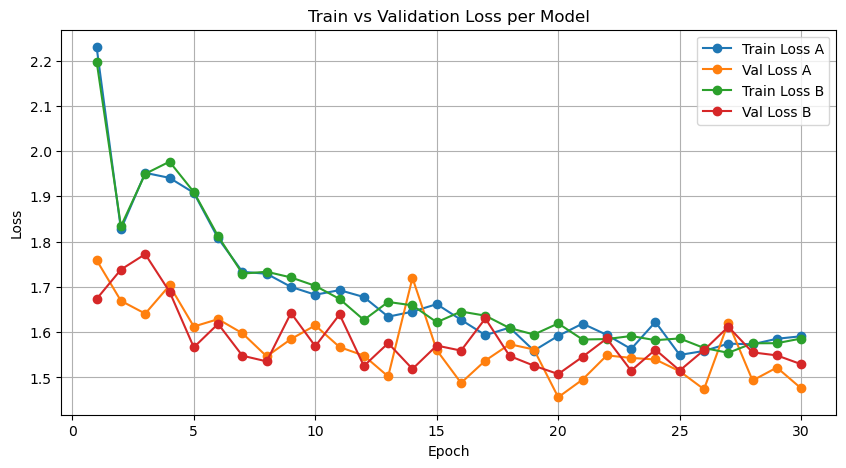

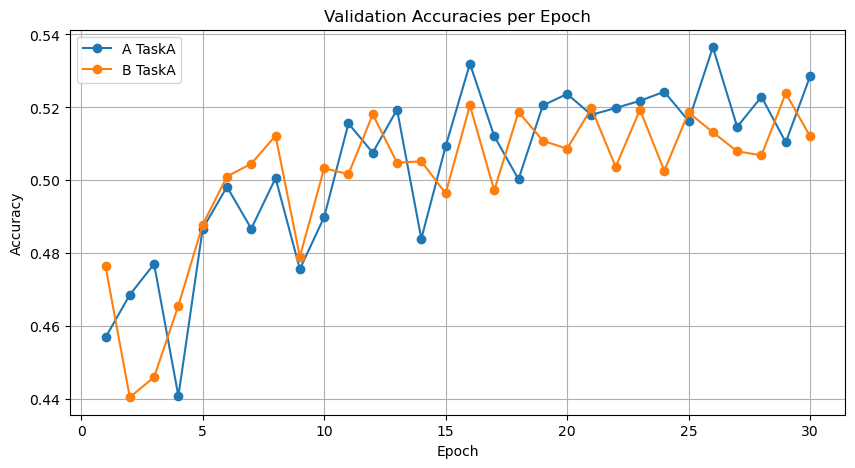

In [27]:
plot_training_metrics("training_metrics_head.csv", train_clas=True)

## Train full Model

In [28]:
Use_Old_Cpkt = True
if Use_Old_Cpkt:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_A.load_state_dict(torch.load("best_model_A.pt", map_location=device))
    model_B.load_state_dict(torch.load("best_model_B.pt", map_location=device))
    model_A.to(device)
    model_B.to(device)

In [29]:
# ===============================================================
#                TRAINING CONFIGURATION
# ===============================================================
lr_head = 1e-4  # slow learning rate for sentiment head
lr_backbone  = 1e-5 # Very slow learning rate for backbone
# 2️⃣ Get DataLoaders
batch_size = 32
train_loader, val_loader, test_loader = get_multi_task_loaders(
    train_df, val_df, test_df, batch_size, model_name
)
num_epochs = (
    20  # Change this to train for more epochs, we trained our model for 5 epochs
)
steps_per_epoch = len(train_loader)  # number of batches per epoch
total_training_steps = steps_per_epoch * num_epochs

warmup_ratio = 0.1  # 10% of total steps
warmup_steps = int(total_training_steps * warmup_ratio)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# UNFreeze Classification Head
for param in model_A.bert_model.classifier.parameters():
                param.requires_grad = True
for param in model_B.bert_model.classifier.parameters():
                param.requires_grad = True

# UNFreeze BERT parameters
for param in model_A.bert_model.bert.parameters():
    param.requires_grad = True
for param in model_B.bert_model.bert.parameters():
    param.requires_grad = True



# Model A optimizer
optimizer_A = torch.optim.Adam([
    {'params': model_A.bert_model.bert.parameters(), 'lr': lr_backbone},
    {'params': model_A.bert_model.classifier.parameters(), 'lr': lr_head},
    {'params': model_A.new_head.parameters(), 'lr': lr_head},
])

# Model B optimizer
optimizer_B = torch.optim.Adam([
    {'params': model_B.bert_model.bert.parameters(), 'lr': lr_backbone},
    {'params': model_B.bert_model.classifier.parameters(), 'lr': lr_head},
    {'params': model_B.new_head.parameters(), 'lr': lr_head},
])

scheduler_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_A,
    lambda step: min(step / warmup_steps, 1.0)
)

scheduler_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_B,
    lambda step: min(step / warmup_steps, 1.0)
)

# 4️⃣ Define your custom dual-task loss function
# This should return (total_loss, logs)
loss_fn = DualTaskConsistencyLoss(
    lambda_weight=1.0,
    ignore_index=-10,
    # weights=weights_clas
    weights=None
)

# 5️⃣ Training Loop
best_val_loss = float("inf")

# Lists to store metrics per epoch
train_metrics_list = []
val_metrics_list = []

for epoch in range(num_epochs):
    print(f"\n================ Epoch {epoch+1}/{num_epochs} ================\n")

    # ---- TRAIN ----
    train_metrics = train_epoch(
        model_A, model_B,
        train_loader,
        optimizer_A, optimizer_B,
        scheduler_A, scheduler_B,
        device,
        loss_fn
    )

    # ---- VALIDATE ----
    val_metrics = validate_epoch(
        model_A, model_B,
        val_loader,
        device,
        loss_fn
    )

    # ---- LOG METRICS ----
    print(f"Train Loss: {train_metrics['loss']:.4f} | Val Loss: {val_metrics['loss']:.4f}")
    print(
        f"L[TaskA]: {val_metrics['acc_A_taskA']:.3f}, "
        f"L[TaskB]: {val_metrics['acc_A_taskB']:.3f}, "
        f"R[TaskA]: {val_metrics['acc_B_taskA']:.3f}, "
        f"R[TaskB]: {val_metrics['acc_B_taskB']:.3f}"
    )

    # ---- SAVE BEST MODEL ----
    if val_metrics["loss"] < best_val_loss:
        best_val_loss = val_metrics["loss"]
        torch.save(model_A.state_dict(), "final_best_model_A.pt")
        torch.save(model_B.state_dict(), "final_best_model_B.pt")
        print("✅ Saved best models!")

    # ---- STORE METRICS ----
    train_metrics_list.append(train_metrics)
    val_metrics_list.append(val_metrics)

print("\nTraining complete! 🎉")

# ---- Combine metrics ----
all_metrics = []
for epoch, (train_m, val_m) in enumerate(zip(train_metrics_list, val_metrics_list), start=1):
    combined = {
        "epoch": epoch,
        "train_loss": train_m.get("loss", None),
        "val_loss": val_m.get("loss", None),
        "acc_A_taskA": val_m.get("acc_A_taskA", None),
        "acc_A_taskB": val_m.get("acc_A_taskB", None),
        "acc_B_taskA": val_m.get("acc_B_taskA", None),
        "acc_B_taskB": val_m.get("acc_B_taskB", None),
    }
    all_metrics.append(combined)

# ---- Convert to DataFrame ----
df_metrics = pd.DataFrame(all_metrics)

# ---- Save to CSV ----
df_metrics.to_csv("training_metrics.csv", index=False)

print("✅ Saved training metrics to 'training_metrics.csv'")

Map:   0%|          | 0/34511 [00:00<?, ? examples/s]

Map:   0%|          | 0/5752 [00:00<?, ? examples/s]

Map:   0%|          | 0/5752 [00:00<?, ? examples/s]

Using device: cuda

================ Epoch 1/20 ================

Train Loss: 8.8092 | Val Loss: 2.3839
L[TaskA]: 0.539, L[TaskB]: 0.685, R[TaskA]: 0.519, R[TaskB]: 0.693
✅ Saved best models!

================ Epoch 2/20 ================

Train Loss: 5.4976 | Val Loss: 2.1006
L[TaskA]: 0.580, L[TaskB]: 0.723, R[TaskA]: 0.563, R[TaskB]: 0.716
✅ Saved best models!

================ Epoch 3/20 ================

Train Loss: 4.8160 | Val Loss: 1.9076
L[TaskA]: 0.613, L[TaskB]: 0.753, R[TaskA]: 0.595, R[TaskB]: 0.751
✅ Saved best models!

================ Epoch 4/20 ================

Train Loss: 4.1535 | Val Loss: 1.8402
L[TaskA]: 0.630, L[TaskB]: 0.767, R[TaskA]: 0.653, R[TaskB]: 0.771
✅ Saved best models!

================ Epoch 5/20 ================

Train Loss: 3.8067 | Val Loss: 1.6053
L[TaskA]: 0.666, L[TaskB]: 0.778, R[TaskA]: 0.662, R[TaskB]: 0.781
✅ Saved best models!

================ Epoch 6/20 ================

Train Loss: 3.4995 | Val Loss: 1.5064
L[TaskA]: 0.666, L[TaskB]: 0.79

Columns in CSV: ['epoch', 'train_loss', 'val_loss', 'acc_A_taskA', 'acc_A_taskB', 'acc_B_taskA', 'acc_B_taskB']


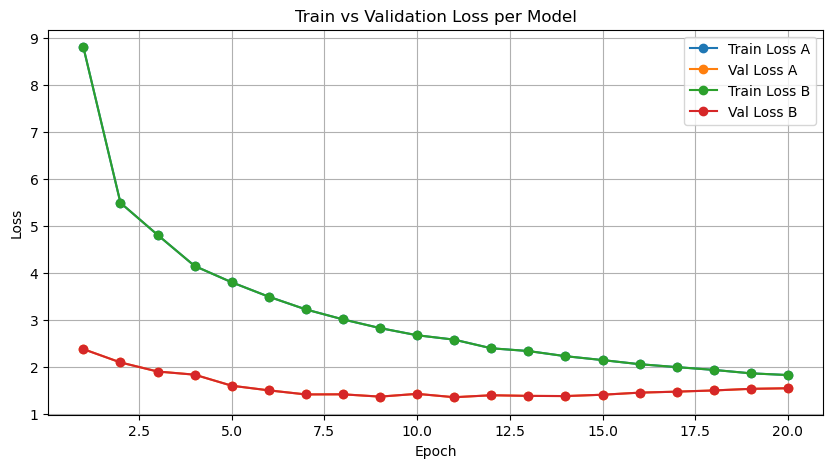

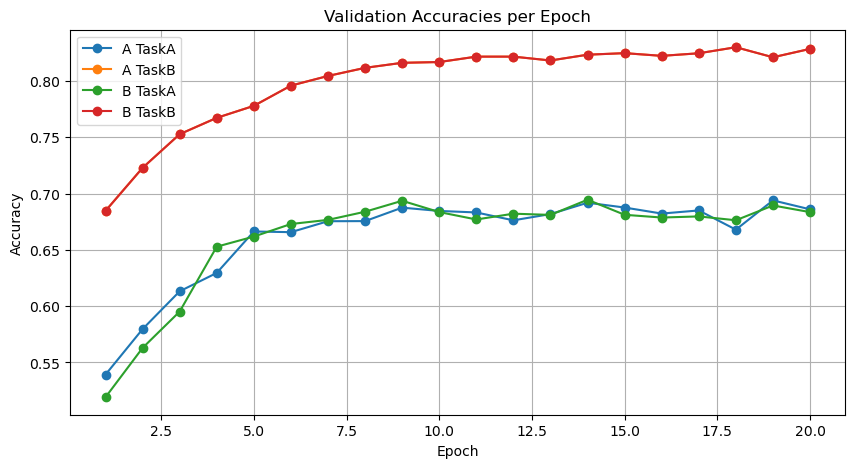

In [30]:
plot_training_metrics("training_metrics.csv", train_clas=False)

In [31]:
    torch.save(model_A.state_dict(), "final_model_A.pt")
    torch.save(model_B.state_dict(), "final_model_B.pt")

## Testing and Metrics

In [25]:
def test_model_single(model, test_loader, device):
    """
    Test a single model on a test dataset without computing loss.
    Args:
        model: The model to evaluate.
        test_loader: Test DataLoader.
        device: torch device.
    Returns:
        Dictionary with accuracies and predictions.
    """
    model.eval()
    # Metric trackers
    acc_taskA = AccumulatingMetric()
    acc_taskB = AccumulatingMetric()
    
    # Store predictions
    predictions = {
        "taskA": [],
        "taskB": [],
        "labels_taskA": [],
        "labels_taskB": []
    }
    
    with torch.no_grad():
        for batch in test_loader:
            # Move batch to device
            for key, val in batch.items():
                batch[key] = val.to(device)
            model.to(device)
            
            # Forward pass
            out_sen, out_clas = model(batch["input_ids"], batch["attention_mask"])
            
            # Compute accuracies
            mask_clas = batch["label_clas"] != -10
            mask_sen = batch["label_sen"] != -10
            
            if mask_clas.any():
                acc_taskA.add(accuracy(out_clas[mask_clas], batch["label_clas"][mask_clas]))
            if mask_sen.any():
                acc_taskB.add(accuracy(out_sen[mask_sen], batch["label_sen"][mask_sen]))
            
            # Save predictions
            predictions["taskA"].append(out_clas.cpu())
            predictions["taskB"].append(out_sen.cpu())
            predictions["labels_taskA"].append(batch["label_clas"].cpu())
            predictions["labels_taskB"].append(batch["label_sen"].cpu())
    
    result = {
        "acc_taskA": acc_taskA.avg(),
        "acc_taskB": acc_taskB.avg(),
        "predictions": predictions
    }
    return result

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models_folder = "."  # Replace with your models folder path
best_model_name_acc = None
best_avg_acc = 0.0
best_result_acc = None
best_model_name_f1 = None
best_avg_f1 = 0.0
best_f1_scores = None
best_f1_weighted_scores = None

# --- Step 1: Evaluate all models ---
for model_file in os.listdir(models_folder):
    if model_file.endswith(".pt"):
        model_path = os.path.join(models_folder, model_file)
        print(f"\nEvaluating {model_file}...")
        model = FrozenBERTMultiHead(
            model_name=model_name,
            num_sentiment_classes=num_sentiment_classes,
            num_new_classes=num_new_classes
        )
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        result = test_model_single(model, test_loader, device)
        
        # --- Accuracy ---
        avg_acc = (result["acc_taskA"] + result["acc_taskB"]) / 2.0
        if avg_acc > best_avg_acc:
            best_avg_acc = avg_acc
            best_model_name_acc = model_file
            best_result_acc = result
        
        # --- Predictions and labels ---
        labels_taskA = torch.cat(result["predictions"]["labels_taskA"]).cpu().numpy()
        preds_taskA = torch.cat(result["predictions"]["taskA"]).argmax(dim=-1).cpu().numpy()
        labels_taskB = torch.cat(result["predictions"]["labels_taskB"]).cpu().numpy()
        preds_taskB = torch.cat(result["predictions"]["taskB"]).argmax(dim=-1).cpu().numpy()
        
        # Filter out ignored labels (-10)
        mask_taskA = labels_taskA != -10
        labels_taskA_filtered = labels_taskA[mask_taskA]
        preds_taskA_filtered = preds_taskA[mask_taskA]
        
        mask_taskB = labels_taskB != -10
        labels_taskB_filtered = labels_taskB[mask_taskB]
        preds_taskB_filtered = preds_taskB[mask_taskB]
        
        # --- F1 (macro + weighted) ---
        f1_taskA_macro = f1_score(labels_taskA_filtered, preds_taskA_filtered, average="macro")
        f1_taskA_weighted = f1_score(labels_taskA_filtered, preds_taskA_filtered, average="weighted")
        f1_taskB_macro = f1_score(labels_taskB_filtered, preds_taskB_filtered, average="macro")
        f1_taskB_weighted = f1_score(labels_taskB_filtered, preds_taskB_filtered, average="weighted")
        
        avg_f1_macro = (f1_taskA_macro + f1_taskB_macro) / 2.0
        avg_f1_weighted = (f1_taskA_weighted + f1_taskB_weighted) / 2.0
        
        print(f"Model {model_file}:")
        print(f"  Accuracy → Class={result['acc_taskA']:.4f}, Sent={result['acc_taskB']:.4f}, Avg={avg_acc:.4f}")
        print(f"  F1 (macro)   → Class={f1_taskA_macro:.4f}, Sent={f1_taskB_macro:.4f}, Avg={avg_f1_macro:.4f}")
        print(f"  F1 (weighted)→ Class={f1_taskA_weighted:.4f}, Sent={f1_taskB_weighted:.4f}, Avg={avg_f1_weighted:.4f}")
        
        # --- Track best macro-F1 model ---
        if avg_f1_macro > best_avg_f1:
            best_avg_f1 = avg_f1_macro
            best_model_name_f1 = model_file
            best_f1_scores = (f1_taskA_macro, f1_taskB_macro)
            best_f1_weighted_scores = (f1_taskA_weighted, f1_taskB_weighted)

# --- Final Summary ---
print("\n=== Best Models Summary ===")
print(f"Best model by accuracy: {best_model_name_acc} | "
      f"Class acc={best_result_acc['acc_taskA']:.4f}, Sent acc={best_result_acc['acc_taskB']:.4f}, Avg acc={best_avg_acc:.4f}")
print(f"Best model by macro F1: {best_model_name_f1} | "
      f"Class F1={best_f1_scores[0]:.4f}, Sent F1={best_f1_scores[1]:.4f}, Avg F1={best_avg_f1:.4f}")
print(f"Weighted F1 (same model): Class={best_f1_weighted_scores[0]:.4f}, "
      f"Sent={best_f1_weighted_scores[1]:.4f}, "
      f"Avg={(best_f1_weighted_scores[0]+best_f1_weighted_scores[1])/2:.4f}")


Evaluating best_model_A.pt...
Model best_model_A.pt:
  Accuracy → Class=0.4986, Sent=0.2666, Avg=0.3826
  F1 (macro)   → Class=0.4720, Sent=0.2666, Avg=0.3693
  F1 (weighted)→ Class=0.5085, Sent=0.2661, Avg=0.3873

Evaluating best_model_B.pt...
Model best_model_B.pt:
  Accuracy → Class=0.4898, Sent=0.2666, Avg=0.3782
  F1 (macro)   → Class=0.4608, Sent=0.2666, Avg=0.3637
  F1 (weighted)→ Class=0.5046, Sent=0.2661, Avg=0.3854

Evaluating final_best_model_A.pt...
Model final_best_model_A.pt:
  Accuracy → Class=0.6804, Sent=0.8351, Avg=0.7577
  F1 (macro)   → Class=0.6841, Sent=0.8317, Avg=0.7579
  F1 (weighted)→ Class=0.6485, Sent=0.8315, Avg=0.7400

Evaluating final_best_model_B.pt...
Model final_best_model_B.pt:
  Accuracy → Class=0.6794, Sent=0.8360, Avg=0.7577
  F1 (macro)   → Class=0.6758, Sent=0.8329, Avg=0.7544
  F1 (weighted)→ Class=0.6477, Sent=0.8327, Avg=0.7402

Evaluating final_model_A.pt...
Model final_model_A.pt:
  Accuracy → Class=0.6673, Sent=0.8324, Avg=0.7499
  F1 (mac

In [37]:
# --- Load best model and predictions (as in your existing code) ---
best_model_path = os.path.join(models_folder, best_model_name_f1)
model = FrozenBERTMultiHead(
    model_name=model_name,
    num_sentiment_classes=num_sentiment_classes,
    num_new_classes=num_new_classes
)
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
result = test_model_single(model, test_loader, device)

# --- Prepare labels and predictions ---
labels_taskA = torch.cat(result["predictions"]["labels_taskA"]).cpu().numpy()
preds_taskA = torch.cat(result["predictions"]["taskA"]).argmax(dim=-1).cpu().numpy()
labels_taskB = torch.cat(result["predictions"]["labels_taskB"]).cpu().numpy()
preds_taskB = torch.cat(result["predictions"]["taskB"]).argmax(dim=-1).cpu().numpy()

# --- Confusion matrices ---
cm_taskA = confusion_matrix(labels_taskA, preds_taskA, labels=np.arange(num_new_classes))
cm_taskA_norm = confusion_matrix(labels_taskA, preds_taskA, labels=np.arange(num_new_classes), normalize='true')

# Task B labels
class_names_B = ["Bearish", "Neutral", "Bullish"]
cm_taskB = confusion_matrix(labels_taskB, preds_taskB, labels=np.arange(3))
cm_taskB_norm = confusion_matrix(labels_taskB, preds_taskB, labels=np.arange(3), normalize='true')

# ===========================
# 💠 Task A (Raw)
# ===========================
plt.figure(figsize=(8, 6))
sns.heatmap(cm_taskA, annot=False, fmt="d", cmap="Blues")
plt.title(f"Task A Confusion Matrix (Raw)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
output_path_A_raw = os.path.join(models_folder, f"{best_model_name_f1}_TaskA_Raw.png")
plt.savefig(output_path_A_raw, dpi=300, bbox_inches="tight")
plt.close()
print(f"Saved: {output_path_A_raw}")

# ===========================
# 💠 Task A (Normalized)
# ===========================
plt.figure(figsize=(8, 6))
sns.heatmap(cm_taskA_norm, annot=False, fmt=".2f", cmap="Blues", vmin=0, vmax=1)
plt.title(f"Task A Confusion Matrix (Normalized)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
output_path_A_norm = os.path.join(models_folder, f"{best_model_name_f1}_TaskA_Normalized.png")
plt.savefig(output_path_A_norm, dpi=300, bbox_inches="tight")
plt.close()
print(f"Saved: {output_path_A_norm}")

# ===========================
# 💠 Task B (Raw) — with labels
# ===========================
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_taskB,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=class_names_B,
    yticklabels=class_names_B
)
plt.title(f"Task B Confusion Matrix (Raw)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
output_path_B_raw = os.path.join(models_folder, f"{best_model_name_f1}_TaskB_Raw.png")
plt.savefig(output_path_B_raw, dpi=300, bbox_inches="tight")
plt.close()
print(f"Saved: {output_path_B_raw}")

# ===========================
# 💠 Task B (Normalized)
# ===========================
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_taskB_norm,
    annot=True,
    fmt=".2f",
    cmap="Greens",
    vmin=0,
    vmax=1,
    xticklabels=class_names_B,
    yticklabels=class_names_B
)
plt.title(f"Task B Confusion Matrix (Normalized)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
output_path_B_norm = os.path.join(models_folder, f"{best_model_name_f1}_TaskB_Normalized.png")
plt.savefig(output_path_B_norm, dpi=300, bbox_inches="tight")
plt.close()
print(f"Saved: {output_path_B_norm}")

Saved: .\final_best_model_A.pt_TaskA_Raw.png
Saved: .\final_best_model_A.pt_TaskA_Normalized.png
Saved: .\final_best_model_A.pt_TaskB_Raw.png
Saved: .\final_best_model_A.pt_TaskB_Normalized.png


## Usage

In [34]:
def load_model_and_predict(
    text,
    model_name,
    model_path,
    mapping_path,
    num_sentiment_classes=3,
    num_new_classes=num_new_classes,
    max_length=128,
):
    """
    Loads a multi-head BERT model, runs inference, and returns readable predictions with probabilities.

    Args:
        text (str): Input text for prediction
        model_name (str): HuggingFace model name
        model_path (str): Path to .pt file containing trained model weights
        mapping_path (str): Path to JSON mapping for company IDs
        num_sentiment_classes (int): Number of sentiment classes (default: 3)
        num_new_classes (int): Number of company classes
        max_length (int): Tokenization max length

    Returns:
        dict: {
            "sentiment_id", "sentiment_label", "sentiment_prob",
            "class_id", "company_name", "class_prob"
        }
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # -------------------------------
    # Load Model & Tokenizer
    # -------------------------------
    model = FrozenBERTMultiHead(
        model_name=model_name,
        num_sentiment_classes=num_sentiment_classes,
        num_new_classes=num_new_classes,
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # -------------------------------
    # Tokenize and Run Inference
    # -------------------------------
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length
    ).to(device)
    inputs.pop("token_type_ids", None)  # avoid unexpected key issues

    with torch.no_grad():
        sentiment_logits, clas_logits = model(**inputs)
        sentiment_probs = F.softmax(sentiment_logits, dim=-1).cpu().numpy()[0]
        class_probs = F.softmax(clas_logits, dim=-1).cpu().numpy()[0]

        sentiment_id = int(torch.argmax(sentiment_logits, dim=-1).item())
        class_id = int(torch.argmax(clas_logits, dim=-1).item())

    # -------------------------------
    # Load Mappings
    # -------------------------------
    with open(mapping_path, "r") as f:
        mapping_data = json.load(f)
    id_to_company = {int(k): v["company"] for k, v in mapping_data["id_to_info"].items()}

    # -------------------------------
    # Helper functions
    # -------------------------------
    def get_company_name_from_id(class_id):
        return id_to_company.get(int(class_id), "Unknown Company")

    def get_sentiment_label(sentiment_id):
        mapping = {0: "Bearish", 1: "Neutral", 2: "Bullish"}
        return mapping.get(int(sentiment_id), "Unknown Sentiment")

    # -------------------------------
    # Build Result
    # -------------------------------
    return {
        "sentiment_id": sentiment_id,
        "sentiment_label": get_sentiment_label(sentiment_id),
        "sentiment_prob": round(float(sentiment_probs[sentiment_id]), 4),
        "class_id": class_id,
        "company_name": get_company_name_from_id(class_id),
        "class_prob": round(float(class_probs[class_id]), 4),
    }

In [35]:
result = load_model_and_predict(
    text="Am considering taking Tesla private at $420. Funding secured.",
    model_name=model_name,
    model_path=best_model_path,
    mapping_path="class_mapping.json"
)

print(f"Sentiment: {result['sentiment_label']} ({result['sentiment_prob']*100:.2f}%)")
print(f"Company: {result['company_name']} ({result['class_prob']*100:.2f}%)")

Sentiment: Bullish (81.28%)
Company: Tesla, Inc. (100.00%)
